<a href="https://colab.research.google.com/github/wnydng/Hackathon-BI-Pipeline/blob/neil/1er_jet_MLmodel_dataset_hackhathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install catboost

In [23]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import average_precision_score
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb


# 1. Chargement des fichiers

In [24]:
transactions_train = pd.read_csv("transactions_train.csv")
cards_data = pd.read_csv("cards_data.csv")
users_data = pd.read_csv("users_data.csv")

with open("train_fraud_labels.json", "r") as f:
    labels_json = json.load(f)
labels_dict = labels_json.get("target", labels_json)
labels_df = pd.DataFrame(list(labels_dict.items()), columns=["transaction_id", "fraud_label"])

with open("mcc_codes.json", "r") as f:
    mcc_codes = json.load(f)
mcc_df = pd.DataFrame(list(mcc_codes.items()), columns=["mcc", "mcc_description"])




# 2. Nettoyage de base

In [25]:
def clean_dollar(x):
    if isinstance(x, str):
        return float(x.replace("$", "").replace(",", ""))
    return x

# Transactions
transactions_train["amount"] = transactions_train["amount"].apply(clean_dollar)
transactions_train["zip"] = transactions_train["zip"].fillna(0).astype(int)
transactions_train["mcc"] = transactions_train["mcc"].astype(str)

# Labels
labels_df["transaction_id"] = labels_df["transaction_id"].astype(int)
labels_df["fraud_label"] = labels_df["fraud_label"].map({"Yes": 1, "No": 0})

# Cartes
cards_data["credit_limit"] = cards_data["credit_limit"].apply(clean_dollar)
cards_data["acct_open_date"] = pd.to_datetime(cards_data["acct_open_date"], errors="coerce")

# Utilisateurs
users_data["yearly_income"] = users_data["yearly_income"].apply(clean_dollar)
users_data["total_debt"] = users_data["total_debt"].apply(clean_dollar)
users_data["per_capita_income"] = users_data["per_capita_income"].apply(clean_dollar)


/tmp/ipython-input-4221679215.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cards_data["acct_open_date"] = pd.to_datetime(cards_data["acct_open_date"], errors="coerce")


# 3. Fusion des datasets

In [26]:
train_merged = transactions_train.merge(labels_df, on="transaction_id", how="left")

merged = (
    train_merged
    .merge(cards_data, left_on="card_id", right_on="id", how="left", suffixes=("", "_card"))
    .merge(users_data, left_on="client_id", right_on="id", how="left", suffixes=("", "_user"))
    .merge(mcc_df, on="mcc", how="left")
)

print("Fusion réussie :", merged.shape)


Fusion réussie : (210000, 41)


# 4. Préparation pour Machine Learning

In [27]:
# On supprime les colonnes inutiles ou non exploitables
drop_cols = [
    "transaction_id", "date", "merchant_city", "merchant_state",
    "address", "card_number", "acct_open_date", "id", "id_card", "id_user"
]
data = merged.drop(columns=[c for c in drop_cols if c in merged.columns], errors="ignore")

# Encodage des variables catégorielles
cat_cols = data.select_dtypes(include=["object"]).columns
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# Suppression des lignes sans label
data = data.dropna(subset=["fraud_label"])

# Séparation X / y
X = data.drop(columns=["fraud_label"])
y = data["fraud_label"].astype(int)

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Dataset prêt pour entraînement")
print("X_train :", X_train.shape, "| y_train :", y_train.shape)
print("Taux de fraude dans le train :", round(y_train.mean()*100, 5), "%")

✅ Dataset prêt pour entraînement
X_train : (168000, 31) | y_train : (168000,)
Taux de fraude dans le train : 0.15 %


## Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- Entraînement ---
log_reg = LogisticRegression(
    class_weight='balanced',  # corrige le déséquilibre des classes
    max_iter=500,
    solver='liblinear',       # bon pour datasets déséquilibrés
    random_state=42
)

log_reg.fit(X_train, y_train)

# --- Prédictions ---
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# --- Évaluation ---
print("✅ Évaluation du modèle Logistique")
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC :", round(roc_auc_score(y_test, y_proba), 5))
auprc = average_precision_score(y_test, y_proba)
print("AUPRC :", round(auprc, 5))

✅ Évaluation du modèle Logistique
Matrice de confusion :
 [[36301  5636]
 [   17    46]]

Rapport de classification :
               precision    recall  f1-score   support

           0     0.9995    0.8656    0.9278     41937
           1     0.0081    0.7302    0.0160        63

    accuracy                         0.8654     42000
   macro avg     0.5038    0.7979    0.4719     42000
weighted avg     0.9980    0.8654    0.9264     42000

ROC-AUC : 0.88729
AUPRC : 0.03009


## XGBoost Classifier

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- Entraînement ---
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=50,  # car très peu de fraudes (~0.15%)
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# --- Évaluation ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("✅ Évaluation du modèle")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC :", round(roc_auc_score(y_test, y_proba), 5))
auprc = average_precision_score(y_test, y_proba)
print("AUPRC :", round(auprc, 5))

✅ Évaluation du modèle
[[41918    19]
 [   37    26]]
              precision    recall  f1-score   support

           0     0.9991    0.9995    0.9993     41937
           1     0.5778    0.4127    0.4815        63

    accuracy                         0.9987     42000
   macro avg     0.7884    0.7061    0.7404     42000
weighted avg     0.9985    0.9987    0.9986     42000

ROC-AUC : 0.96362
AUPRC : 0.43537


## CatBoost Classifier

In [30]:
!pip install catboost

In [31]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- Entraînement ---
cat_model = CatBoostClassifier(
    iterations=1000,            # nombre d'arbres
    depth=8,                    # profondeur de chaque arbre
    learning_rate=0.05,         # taux d'apprentissage
    loss_function='Logloss',
    eval_metric='AUC',
    class_weights=[1, 500],     # fort déséquilibre de classes (~0.15%)
    random_seed=42,
    verbose=200,                # affiche la progression
    task_type="CPU"             # passe à "GPU" si tu en as un
)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# --- Évaluation ---
y_pred = cat_model.predict(X_test)
y_proba = cat_model.predict_proba(X_test)[:, 1]

print("\n✅ Évaluation du modèle CatBoost")
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC :", round(roc_auc_score(y_test, y_proba), 5))
auprc = average_precision_score(y_test, y_proba)
print("AUPRC :", round(auprc, 5))


0:	test: 0.9141318	best: 0.9141318 (0)	total: 215ms	remaining: 3m 35s
200:	test: 0.9664096	best: 0.9667975 (187)	total: 32.8s	remaining: 2m 10s
400:	test: 0.9710212	best: 0.9710352 (352)	total: 47.7s	remaining: 1m 11s
600:	test: 0.9710212	best: 0.9710352 (352)	total: 1m	remaining: 40.2s
800:	test: 0.9710212	best: 0.9710352 (352)	total: 1m 13s	remaining: 18.2s
999:	test: 0.9710212	best: 0.9710352 (352)	total: 1m 26s	remaining: 0us

bestTest = 0.971035162
bestIteration = 352

Shrink model to first 353 iterations.

✅ Évaluation du modèle CatBoost
Matrice de confusion :
 [[41880    57]
 [   36    27]]

Rapport de classification :
               precision    recall  f1-score   support

           0     0.9991    0.9986    0.9989     41937
           1     0.3214    0.4286    0.3673        63

    accuracy                         0.9978     42000
   macro avg     0.6603    0.7136    0.6831     42000
weighted avg     0.9981    0.9978    0.9979     42000

ROC-AUC : 0.97104
AUPRC : 0.40438


# LightGBM

In [32]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

# --- Entraînement ---
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,          # nombre d'arbres
    learning_rate=0.03,         # taux d'apprentissage
    num_leaves=64,              # complexité des arbres
    max_depth=-1,               # -1 = pas de limite de profondeur
    subsample=0.8,              # échantillonnage pour éviter l'overfitting
    colsample_bytree=0.8,
    objective='binary',
    class_weight='balanced',    # gère le déséquilibre
    random_state=42,
    n_jobs=-1                   # exploitation multi-core
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
)

# --- Évaluation ---
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]

print("\n✅ Évaluation du modèle LightGBM")
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred, digits=4))

auroc = roc_auc_score(y_test, y_proba)
auprc = average_precision_score(y_test, y_proba)
print(f"ROC-AUC : {auroc:.5f}")
print(f"AUPRC   : {auprc:.5f}")

[LightGBM] [Info] Number of positive: 252, number of negative: 167748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 168000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ Évaluation du modèle LightGBM
Matrice de confusion :
 [[41931     6]
 [   40    23]]

Rapport de classification :
               precision    recall  f1-score   support

           0     0.9990    0.9999    0.9995     41937
           1     0.7931    0.3651    0.5000        63

    accuracy                         0.9989     42000
   macro avg     0.8961    0.6825    0.7497     42000
weighted avg     0.9987    0.9989    0.9987     42000

ROC-AUC : 0.97350
AUPRC   : 0.54938


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("=== Split classique ===")
print("ROC-AUC :", roc_auc_score(y_test, y_proba))
print("AUPRC   :", average_precision_score(y_test, y_proba))
print("F1      :", f1_score(y_test, y_pred))



=== Split classique ===
ROC-AUC : 0.9636204117211341
AUPRC   : 0.4353748449214941
F1      : 0.48148148148148145


In [34]:
# ======================================
# 🚀 Évaluation multi-splits (classique / temporel / cold-start)
# ======================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

# -------------------------------
# 0. Préparation des données
# -------------------------------

# On part du dataframe fusionné "merged"
df = merged.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

# Nettoyage des valeurs manquantes
df = df.dropna(subset=["fraud_label"])

# Conversion des catégories en string
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str)

# Suppression des colonnes inutiles
drop_cols = [
    "transaction_id", "date", "merchant_city", "merchant_state",
    "address", "card_number", "acct_open_date", "mcc_description", "id", "id_user"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Séparation features / label
X = df.drop(columns=["fraud_label"])
y = df["fraud_label"]

# Encodage simple et robuste
cat_cols = X.select_dtypes(include=["object"]).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# 1️⃣ Split Classique (aléatoire)
# -------------------------------
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Split classique effectué :")
print("Train :", X_train_cl.shape, "| Test :", X_test_cl.shape)

# -------------------------------
# 2️⃣ Split Temporel (train < 2018, test = 2018)
# -------------------------------
train_temp = df[df["year"] < 2018]
test_temp  = df[df["year"] == 2018]

X_train_temp = train_temp.drop(columns=["fraud_label"])
y_train_temp = train_temp["fraud_label"]
X_test_temp  = test_temp.drop(columns=["fraud_label"])
y_test_temp  = test_temp["fraud_label"]

for col in X_train_temp.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_train_temp[col] = le.fit_transform(X_train_temp[col].astype(str))
    X_test_temp[col]  = X_test_temp[col].apply(lambda x: x if x in le.classes_ else "<UNK>")
    le.classes_ = np.append(le.classes_, "<UNK>")
    X_test_temp[col] = le.transform(X_test_temp[col])

scaler = StandardScaler()
X_train_temp = scaler.fit_transform(X_train_temp)
X_test_temp  = scaler.transform(X_test_temp)

print("✅ Split temporel effectué :")
print("Train :", X_train_temp.shape, "| Test :", X_test_temp.shape)

# -------------------------------
# 3️⃣ Split Cold-Start (GroupShuffleSplit)
# -------------------------------
clients = df["client_id"].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_scaled, y, groups=clients))

X_train_cs, X_test_cs = X_scaled[train_idx], X_scaled[test_idx]
y_train_cs, y_test_cs = y.iloc[train_idx], y.iloc[test_idx]

print("✅ Split cold-start clients :")
print("Train :", X_train_cs.shape, "| Test :", X_test_cs.shape)

# -------------------------------
# 4️⃣ Entraînement d’un modèle (LightGBM en exemple)
# -------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_proba)
    auprc = average_precision_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    print(f"\n🔹 {name}")
    print("ROC-AUC :", round(auroc, 5))
    print("AUPRC   :", round(auprc, 5))
    print("F1      :", round(f1, 5))
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
    print("Rapport :\n", classification_report(y_test, y_pred, digits=4))

# Exemple modèle : LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=64,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# -------------------------------
# 5️⃣ Évaluation sur les 3 splits
# -------------------------------
print("\n=== 🔥 Évaluation LightGBM sur les 3 splits ===")

evaluate_model("Split classique", lgb_model, X_train_cl, X_test_cl, y_train_cl, y_test_cl)
evaluate_model("Split temporel (2016–2017 ➜ 2018)", lgb_model, X_train_temp, X_test_temp, y_train_temp, y_test_temp)
evaluate_model("Split cold-start (GroupShuffleSplit clients)", lgb_model, X_train_cs, X_test_cs, y_train_cs, y_test_cs)


✅ Split classique effectué :
Train : (168000, 31) | Test : (42000, 31)
✅ Split temporel effectué :
Train : (140115, 31) | Test : (69885, 31)
✅ Split cold-start clients :
Train : (168621, 31) | Test : (41379, 31)

=== 🔥 Évaluation LightGBM sur les 3 splits ===
[LightGBM] [Info] Number of positive: 252, number of negative: 167748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3998
[LightGBM] [Info] Number of data points in the train set: 168000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔹 Split classique
ROC-AUC : 0.97992
AUPRC   : 0.64614
F1      : 0.64078
Matrice de confusion :
 [[41930     7]
 [   30    33]]
Rapport :
               precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     41937
           1     0.8250    0.5238    0.6408        63

    accuracy                         0.9991     42000
   macro avg     0.9121    0.7618    0.8202     42000
weighted avg     0.9990    0.9991    0.9990     42000

[LightGBM] [Info] Number of positive: 201, number of negative: 139914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3997
[LightGBM] [Info] Number of data points in the train set: 140115, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start traini

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔹 Split temporel (2016–2017 ➜ 2018)
ROC-AUC : 0.9709
AUPRC   : 0.38628
F1      : 0.13008
Matrice de confusion :
 [[69770     1]
 [  106     8]]
Rapport :
               precision    recall  f1-score   support

           0     0.9985    1.0000    0.9992     69771
           1     0.8889    0.0702    0.1301       114

    accuracy                         0.9985     69885
   macro avg     0.9437    0.5351    0.5647     69885
weighted avg     0.9983    0.9985    0.9978     69885

[LightGBM] [Info] Number of positive: 239, number of negative: 168382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3974
[LightGBM] [Info] Number of data points in the train set: 168621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [In

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔹 Split cold-start (GroupShuffleSplit clients)
ROC-AUC : 0.99208
AUPRC   : 0.67464
F1      : 0.59375
Matrice de confusion :
 [[41289    14]
 [   38    38]]
Rapport :
               precision    recall  f1-score   support

           0     0.9991    0.9997    0.9994     41303
           1     0.7308    0.5000    0.5938        76

    accuracy                         0.9987     41379
   macro avg     0.8649    0.7498    0.7966     41379
weighted avg     0.9986    0.9987    0.9986     41379



In [35]:
evaluate_model("Classique", lgb_model, X_train_cl, X_test_cl, y_train_cl, y_test_cl)
evaluate_model("Temporel (2016–2017 ➜ 2018)", lgb_model, X_train_temp, X_test_temp, y_train_temp, y_test_temp)
evaluate_model("Cold-Start (nouveaux clients)", lgb_model, X_train_cs, X_test_cs, y_train_cs, y_test_cs)

# Affichage du résumé global
results_df = pd.DataFrame(results_summary)
print("\n📊 Résumé global des performances du modèle :")
print(results_df.to_string(index=False))

[LightGBM] [Info] Number of positive: 252, number of negative: 167748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3998
[LightGBM] [Info] Number of data points in the train set: 168000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔹 Classique
ROC-AUC : 0.97992
AUPRC   : 0.64614
F1      : 0.64078
Matrice de confusion :
 [[41930     7]
 [   30    33]]
Rapport :
               precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     41937
           1     0.8250    0.5238    0.6408        63

    accuracy                         0.9991     42000
   macro avg     0.9121    0.7618    0.8202     42000
weighted avg     0.9990    0.9991    0.9990     42000

[LightGBM] [Info] Number of positive: 201, number of negative: 139914
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3997
[LightGBM] [Info] Number of data points in the train set: 140115, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with po

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔹 Temporel (2016–2017 ➜ 2018)
ROC-AUC : 0.9709
AUPRC   : 0.38628
F1      : 0.13008
Matrice de confusion :
 [[69770     1]
 [  106     8]]
Rapport :
               precision    recall  f1-score   support

           0     0.9985    1.0000    0.9992     69771
           1     0.8889    0.0702    0.1301       114

    accuracy                         0.9985     69885
   macro avg     0.9437    0.5351    0.5647     69885
weighted avg     0.9983    0.9985    0.9978     69885

[LightGBM] [Info] Number of positive: 239, number of negative: 168382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3974
[LightGBM] [Info] Number of data points in the train set: 168621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] St

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔹 Cold-Start (nouveaux clients)
ROC-AUC : 0.99208
AUPRC   : 0.67464
F1      : 0.59375
Matrice de confusion :
 [[41289    14]
 [   38    38]]
Rapport :
               precision    recall  f1-score   support

           0     0.9991    0.9997    0.9994     41303
           1     0.7308    0.5000    0.5938        76

    accuracy                         0.9987     41379
   macro avg     0.8649    0.7498    0.7966     41379
weighted avg     0.9986    0.9987    0.9986     41379



NameError: name 'results_summary' is not defined

In [36]:
results_summary = []

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_proba)
    auprc = average_precision_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    # Sauvegarde des scores
    results_summary.append({
        "Split": name,
        "ROC-AUC": round(auroc, 5),
        "AUPRC": round(auprc, 5),
        "F1": round(f1, 5)
    })

    print(f"\n🔹 {name}")
    print(f"ROC-AUC: {auroc:.5f} | AUPRC: {auprc:.5f} | F1: {f1:.5f}")
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
    print("Rapport :\n", classification_report(y_test, y_pred, digits=4))

# (réexécute tes 3 splits ici)
evaluate_model("Classique", lgb_model, X_train_cl, X_test_cl, y_train_cl, y_test_cl)
evaluate_model("Temporel (2016–2017 ➜ 2018)", lgb_model, X_train_temp, X_test_temp, y_train_temp, y_test_temp)
evaluate_model("Cold-Start (nouveaux clients)", lgb_model, X_train_cs, X_test_cs, y_train_cs, y_test_cs)

[LightGBM] [Info] Number of positive: 252, number of negative: 167748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3998
[LightGBM] [Info] Number of data points in the train set: 168000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔹 Classique
ROC-AUC: 0.97992 | AUPRC: 0.64614 | F1: 0.64078
Matrice de confusion :
 [[41930     7]
 [   30    33]]
Rapport :
               precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     41937
           1     0.8250    0.5238    0.6408        63

    accuracy                         0.9991     42000
   macro avg     0.9121    0.7618    0.8202     42000
weighted avg     0.9990    0.9991    0.9990     42000

[LightGBM] [Info] Number of positive: 201, number of negative: 139914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3997
[LightGBM] [Info] Number of data points in the train set: 140115, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from scor

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔹 Temporel (2016–2017 ➜ 2018)
ROC-AUC: 0.97090 | AUPRC: 0.38628 | F1: 0.13008
Matrice de confusion :
 [[69770     1]
 [  106     8]]
Rapport :
               precision    recall  f1-score   support

           0     0.9985    1.0000    0.9992     69771
           1     0.8889    0.0702    0.1301       114

    accuracy                         0.9985     69885
   macro avg     0.9437    0.5351    0.5647     69885
weighted avg     0.9983    0.9985    0.9978     69885

[LightGBM] [Info] Number of positive: 239, number of negative: 168382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3974
[LightGBM] [Info] Number of data points in the train set: 168621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start t

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔹 Cold-Start (nouveaux clients)
ROC-AUC: 0.99208 | AUPRC: 0.67464 | F1: 0.59375
Matrice de confusion :
 [[41289    14]
 [   38    38]]
Rapport :
               precision    recall  f1-score   support

           0     0.9991    0.9997    0.9994     41303
           1     0.7308    0.5000    0.5938        76

    accuracy                         0.9987     41379
   macro avg     0.8649    0.7498    0.7966     41379
weighted avg     0.9986    0.9987    0.9986     41379



In [37]:
# Affichage du résumé global
results_df = pd.DataFrame(results_summary)
print("\n📊 Résumé global des performances du modèle :")
print(results_df.to_string(index=False))


📊 Résumé global des performances du modèle :
                        Split  ROC-AUC   AUPRC      F1
                    Classique  0.97992 0.64614 0.64078
  Temporel (2016–2017 ➜ 2018)  0.97090 0.38628 0.13008
Cold-Start (nouveaux clients)  0.99208 0.67464 0.59375


In [39]:
# ======================================
# 📋 Résumé synthétique pour 3 modèles et 3 splits
# ======================================

results_summary = []
# =========================
# ⚙️ Définition des 3 modèles
# =========================

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

# Régression Logistique
log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=500,
    solver="liblinear",
    random_state=42
)

# XGBoost
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=50,   # déséquilibre des classes
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=64,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

def evaluate_model(name_split, model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    auroc = roc_auc_score(y_test, y_proba)
    auprc = average_precision_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    # Sauvegarde
    results_summary.append({
        "Modèle": model_name,
        "Split": name_split,
        "ROC-AUC": round(auroc, 5),
        "AUPRC": round(auprc, 5),
        "F1": round(f1, 5)
    })

# =========================
# 1️⃣ Régression Logistique
# =========================
evaluate_model("Classique", "Logistic Regression", log_reg, X_train_cl, X_test_cl, y_train_cl, y_test_cl)
evaluate_model("Temporel", "Logistic Regression", log_reg, X_train_temp, X_test_temp, y_train_temp, y_test_temp)
evaluate_model("Cold-start", "Logistic Regression", log_reg, X_train_cs, X_test_cs, y_train_cs, y_test_cs)

# =========================
# 2️⃣ XGBoost
# =========================
evaluate_model("Classique", "XGBoost", xgb_model, X_train_cl, X_test_cl, y_train_cl, y_test_cl)
evaluate_model("Temporel", "XGBoost", xgb_model, X_train_temp, X_test_temp, y_train_temp, y_test_temp)
evaluate_model("Cold-start", "XGBoost", xgb_model, X_train_cs, X_test_cs, y_train_cs, y_test_cs)

# =========================
# 3️⃣ LightGBM
# =========================
evaluate_model("Classique", "LightGBM", lgb_model, X_train_cl, X_test_cl, y_train_cl, y_test_cl)
evaluate_model("Temporel", "LightGBM", lgb_model, X_train_temp, X_test_temp, y_train_temp, y_test_temp)
evaluate_model("Cold-start", "LightGBM", lgb_model, X_train_cs, X_test_cs, y_train_cs, y_test_cs)


[LightGBM] [Info] Number of positive: 252, number of negative: 167748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3998
[LightGBM] [Info] Number of data points in the train set: 168000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 201, number of negative: 139914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3997
[LightGBM] [Info] Number of data points in the train set: 140115, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 239, number of negative: 168382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3974
[LightGBM] [Info] Number of data points in the train set: 168621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📊 Résumé global des performances :
            ROC-AUC                                AUPRC                      \
Modèle     LightGBM Logistic Regression XGBoost LightGBM Logistic Regression   
Split                                                                          
Classique    0.9799              0.8904  0.9714   0.6461              0.0193   
Cold-start   0.9921              0.9218  0.9912   0.6746              0.0185   
Temporel     0.9709              0.9070  0.9687   0.3863              0.0121   

                         F1                              
Modèle     XGBoost LightGBM Logistic Regression XGBoost  
Split                                                    
Classique   0.4480   0.6408              0.0154  0.4706  
Cold-start  0.5460   0.5938              0.0212  0.5333  
Temporel    0.3366   0.1301              0.0276  0.0984  


In [40]:
# Résumé final
results_df = pd.DataFrame(results_summary)
print("\n📊 Résumé global des performances :")
print(results_df.pivot(index="Split", columns="Modèle", values=["ROC-AUC", "AUPRC", "F1"]).round(4))


📊 Résumé global des performances :
            ROC-AUC                                AUPRC                      \
Modèle     LightGBM Logistic Regression XGBoost LightGBM Logistic Regression   
Split                                                                          
Classique    0.9799              0.8904  0.9714   0.6461              0.0193   
Cold-start   0.9921              0.9218  0.9912   0.6746              0.0185   
Temporel     0.9709              0.9070  0.9687   0.3863              0.0121   

                         F1                              
Modèle     XGBoost LightGBM Logistic Regression XGBoost  
Split                                                    
Classique   0.4480   0.6408              0.0154  0.4706  
Cold-start  0.5460   0.5938              0.0212  0.5333  
Temporel    0.3366   0.1301              0.0276  0.0984  


/tmp/ipython-input-2845045069.py:18: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


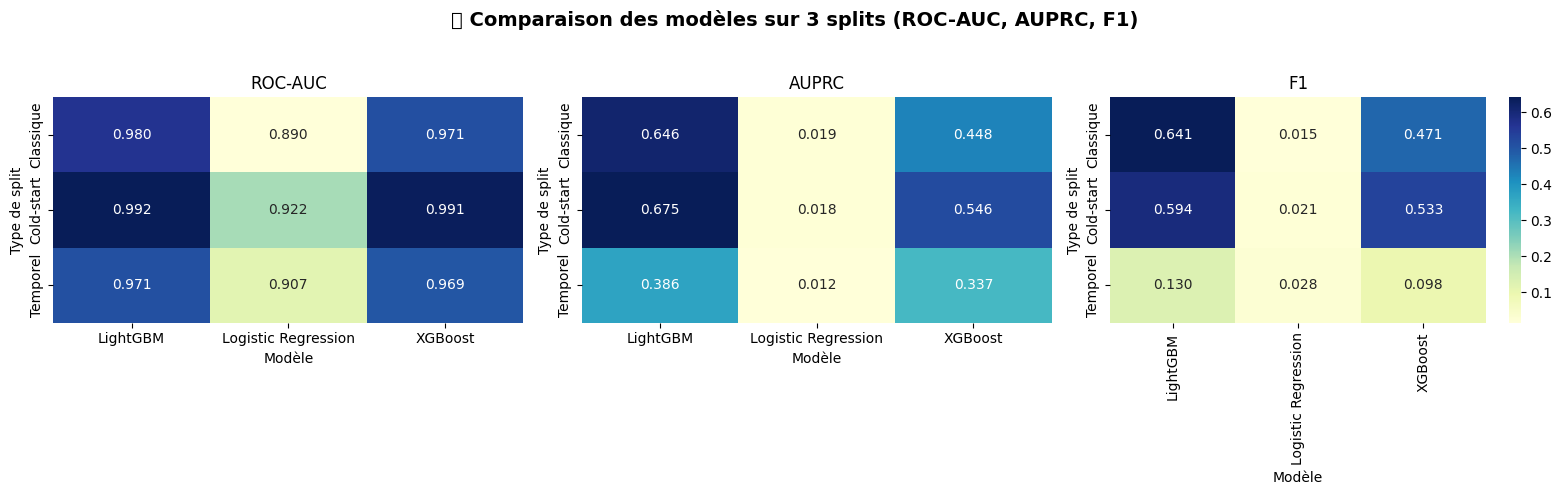

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crée un tableau propre
results_df = pd.DataFrame(results_summary)
metrics = ["ROC-AUC", "AUPRC", "F1"]

# Création des 3 heatmaps côte à côte
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i, metric in enumerate(metrics):
    pivot = results_df.pivot(index="Split", columns="Modèle", values=metric)
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu", ax=axes[i], cbar=i==2)
    axes[i].set_title(metric)
    axes[i].set_xlabel("Modèle")
    axes[i].set_ylabel("Type de split")

plt.suptitle("🔥 Comparaison des modèles sur 3 splits (ROC-AUC, AUPRC, F1)", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


[LightGBM] [Info] Number of positive: 252, number of negative: 167748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3998
[LightGBM] [Info] Number of data points in the train set: 168000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 201, number of negative: 139914
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3997
[LightGBM] [Info] Number of data points in the train set: 140115, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 239, number of negative: 168382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3974
[LightGBM] [Info] Number of data points in the train set: 168621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📊 Résumé global des performances :
            ROC-AUC                                         AUPRC           \
Modèle     CatBoost LightGBM Logistic Regression XGBoost CatBoost LightGBM   
Split                                                                        
Classique    0.9832   0.9799              0.8904  0.9714   0.4596   0.6461   
Cold-start   0.9910   0.9921              0.9218  0.9912   0.5812   0.6746   
Temporel     0.9873   0.9709              0.9070  0.9687   0.3245   0.3863   

                                             F1                               \
Modèle     Logistic Regression XGBoost CatBoost LightGBM Logistic Regression   
Split                                                                          
Classique               0.0193  0.4480   0.4595   0.6408              0.0154   
Cold-start              0.0185  0.5460   0.5426   0.5938              0.0212   
Temporel                0.0121  0.3366   0.0656   0.1301              0.0276   

              

/tmp/ipython-input-4148354746.py:85: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


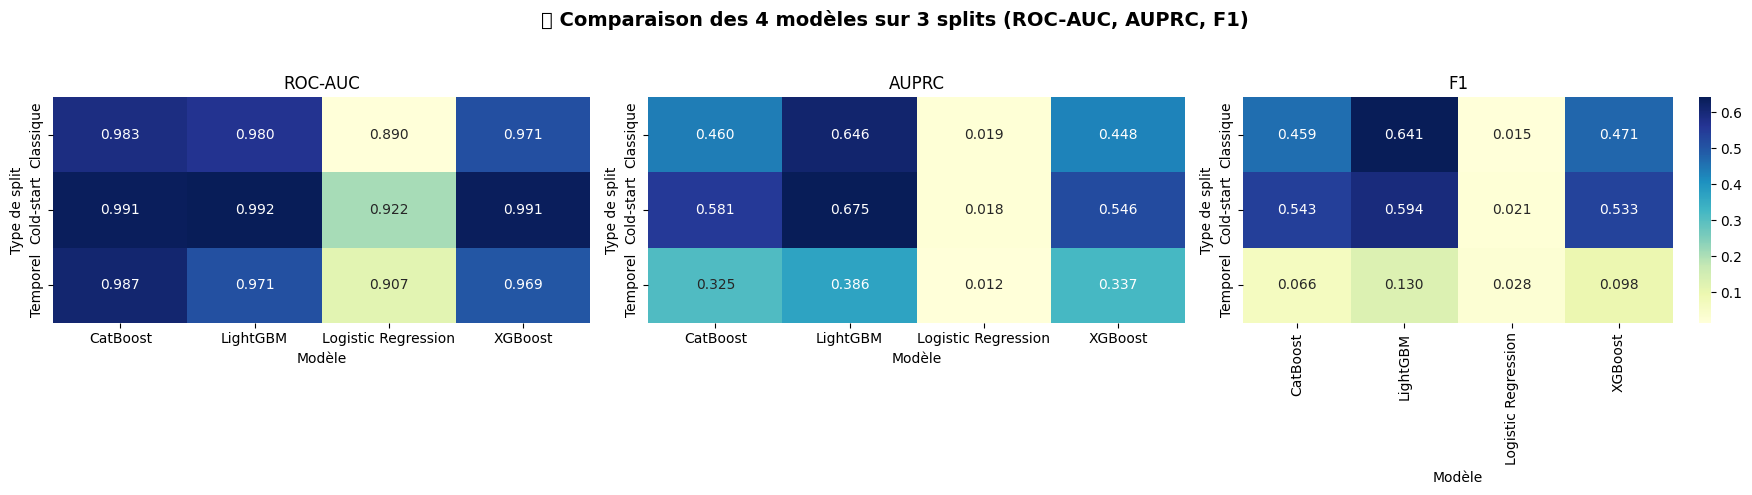

In [46]:
# ======================================
# ⚙️ Définition de CatBoost
# ======================================

from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=800,
    depth=8,
    learning_rate=0.05,
    class_weights=[1, 500],
    verbose=0,
    random_seed=42
)

# ======================================
# 📊 Évaluation sur les 3 splits
# ======================================

# Réinitialise le résumé
results_summary = []

def evaluate_model(name_split, model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_proba)
    auprc = average_precision_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    results_summary.append({
        "Modèle": model_name,
        "Split": name_split,
        "ROC-AUC": round(auroc, 5),
        "AUPRC": round(auprc, 5),
        "F1": round(f1, 5)
    })

# --- Logistic Regression ---
evaluate_model("Classique", "Logistic Regression", log_reg, X_train_cl, X_test_cl, y_train_cl, y_test_cl)
evaluate_model("Temporel", "Logistic Regression", log_reg, X_train_temp, X_test_temp, y_train_temp, y_test_temp)
evaluate_model("Cold-start", "Logistic Regression", log_reg, X_train_cs, X_test_cs, y_train_cs, y_test_cs)

# --- XGBoost ---
evaluate_model("Classique", "XGBoost", xgb_model, X_train_cl, X_test_cl, y_train_cl, y_test_cl)
evaluate_model("Temporel", "XGBoost", xgb_model, X_train_temp, X_test_temp, y_train_temp, y_test_temp)
evaluate_model("Cold-start", "XGBoost", xgb_model, X_train_cs, X_test_cs, y_train_cs, y_test_cs)

# --- LightGBM ---
evaluate_model("Classique", "LightGBM", lgb_model, X_train_cl, X_test_cl, y_train_cl, y_test_cl)
evaluate_model("Temporel", "LightGBM", lgb_model, X_train_temp, X_test_temp, y_train_temp, y_test_temp)
evaluate_model("Cold-start", "LightGBM", lgb_model, X_train_cs, X_test_cs, y_train_cs, y_test_cs)

# --- CatBoost ---
evaluate_model("Classique", "CatBoost", cat_model, X_train_cl, X_test_cl, y_train_cl, y_test_cl)
evaluate_model("Temporel", "CatBoost", cat_model, X_train_temp, X_test_temp, y_train_temp, y_test_temp)
evaluate_model("Cold-start", "CatBoost", cat_model, X_train_cs, X_test_cs, y_train_cs, y_test_cs)

# ======================================
# 🧾 Résumé global
# ======================================

results_df = pd.DataFrame(results_summary)
pivot = results_df.pivot(index="Split", columns="Modèle", values=["ROC-AUC", "AUPRC", "F1"]).round(4)
print("\n📊 Résumé global des performances :")
print(pivot)

# ======================================
# 🔥 Heatmaps comparatives (3 métriques)
# ======================================

import seaborn as sns
import matplotlib.pyplot as plt

metrics = ["ROC-AUC", "AUPRC", "F1"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    pivot = results_df.pivot(index="Split", columns="Modèle", values=metric)
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu", ax=axes[i], cbar=i==2)
    axes[i].set_title(metric)
    axes[i].set_xlabel("Modèle")
    axes[i].set_ylabel("Type de split")

plt.suptitle("💥 Comparaison des 4 modèles sur 3 splits (ROC-AUC, AUPRC, F1)", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()